In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os,random

# Input Data
------------
[You can find it here](https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset) </br>
**Add by API**: ```kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset```

In [2]:
data = []
DataDir = '../input/microsoft-catsvsdogs-dataset/PetImages'
types = ['Cat','Dog']
img_size = 50
for type in types:
    print(type)
    path = os.path.join(DataDir,type)
    type_num = types.index(type)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path,img))
            new_array = cv2.resize(img_array,(img_size,img_size))
            data.append([new_array,type_num])
        except:
            print("bad file")

In [3]:
data = np.array(data)
dogs = 0
cats = 0
for i in range(data.shape[0]):
    if data[i][1]==1:
        dogs+=1
    elif data[i][1]==0:
        cats+=1

print(f'No of dogs = {dogs} & no of cats = {cats}')

print(data.shape)
t = data.shape[0]

In [4]:
##### splitting dataset
np.random.shuffle(data)
training_data,testing_data = data[:int(t/40)],data[int(t/80):]

In [5]:
#cats and dogs number caheck
count_dog = 0
count_cat = 0
for i in range(training_data.shape[0]):
    if training_data[i][1] == 1:
        count_dog+=1
    elif training_data[i][1]==0:
        count_cat+=1
        
print(f' dog count = {count_dog}\n cat count = {count_cat}')
print(dogs)

In [6]:
x_train = []
y_train = []

for i in range(training_data.shape[0]):
    x_train.append(training_data[i][0])
    y_train.append(training_data[i][1])

x_train = np.array(x_train)
y_train = np.array(y_train).reshape(-1,1).T
print(f'x_train = {x_train.shape}\ny_train = {y_train.shape}')

In [7]:
# x_train = x_train/255

In [8]:
x_test = []
y_test = []
for i in range(testing_data.shape[0]):
    x_test.append(testing_data[i][0])
    y_test.append(testing_data[i][1])

x_test = np.array(x_test)
y_test = np.array(y_test).reshape(-1,1).T

In [9]:
plt.imshow(x_train[9])
c_dog = 0
c_cat = 0
for i in range(y_train.shape[1]):
    if y_train[0][i] == 1:
        c_dog+=1
    elif y_train[0][i] == 0:
        c_cat+=1
print(f' dog count = {c_dog}\n cat count = {c_cat}')
        

In [10]:
x_train = x_train.reshape(-1,img_size*img_size*3).T
print(x_train.shape)
x_train = x_train

x_test = x_test.reshape(-1,img_size*img_size*3).T
x_test = x_test

In [11]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def ReLU(Z):
    return np.maximum(Z,0)

In [12]:
layer_dims = [x_train.shape[0],20,5,1]

def initialize_parameters_deep(layer_dims):
    params = []
    for i in range(1,len(layer_dims)):
        W =  np.random.randn(layer_dims[i],layer_dims[i-1])*0.01
        b = np.zeros((layer_dims[i],1))*0.01

        dic = {
            "W":W,
            "b":b
        }
        params.append(dic)
    #eg: params = [W1,b1,W2,b2....]
    # print(f'params = {params}')
    return params

def linear_activation_forward(A_prev,W,b, activation):
    
#     print(f'shape of W,A_prev = {W.shape}, {A_prev.shape}')

    Z = np.dot(W,A_prev) + b

#     print(f'shape of Z = {Z.shape}')
    
    if activation == "sigmoid":
        A = sigmoid(Z)

    elif activation == "relu":
        A = ReLU(Z)
        
    cache = (A_prev,A,W,b)
    
    return A, cache 

def L_model_forward(X,params):
    #size of layer
    L = len(params)-1
    caches = []
    A = X

#     print(f'length of params = {L}')
    for l in range(0,L):
        A_prev = A
        W,b = params[l]["W"],params[l]["b"]
        A,cache = linear_activation_forward(A_prev,W,b,"relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A,params[L]["W"],params[L]["b"],"sigmoid")
    caches.append(cache)

    return AL, caches


def compute_cost(AL,Y):
    m = Y.shape[1]
    
#     print(f'shape of AL,Y = {AL.shape}, {Y.shape}')
    cost = -1/m * np.sum(np.multiply(Y,np.log(AL)) + np.multiply(1-Y,np.log(1-AL)))
    cost = np.squeeze(cost)

    return cost

In [13]:
#backward prop
def relu_backward(dA, cache):
    A_prev,A,W,b = cache
    A[A>=0] = 1
    A[A<0] = 0
    
#     print(f'shape dZ_prev: {dZ_prev.shape},shape A: {A.shape}')
    dZ = np.multiply(dA,A)
    return dZ

def sigmoid_backward(dA, cache):
    A_prev,A,W,b = cache
    dZ = np.multiply(A,(1-A))
    dZ = np.multiply(dA,dZ)
#     print(f'shape of A, dZ: {A.shape}, {dZ.shape}')
    return dZ

def L_activation_backward(dA, cache, activation):
    A_prev, A, W, b = cache
    m = A_prev.shape[1]

    if activation == "relu":
        dZ = relu_backward(dA, cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,cache)

    dW = 1/m* np.dot(dZ,A_prev.T)
    db = 1/m* np.sum(dZ, axis=1, keepdims=True)
    
#     print(f'shape of a_prev, W.T and dZ are : {A_prev.shape}, {W.T.shape}, {dZ.shape}')
    
    dA_prev = np.dot(W.T,dZ)
    
#     print(f'shape of A_prev, dA, dz, dW:{A_prev.shape}, {dA_prev.shape}, {dZ.shape}, {dW.shape}')
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    # Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
#     print(f'shape of dAL = {dAL.shape}')
    current_cache = caches[L-1]
#     print(f'value of l: {L-1}')
    dA_prev_temp, dW_temp, db_temp = L_activation_backward(dAL,current_cache,"sigmoid")

    grads["dA"+str(L-1)] = dA_prev_temp
    grads["dW"+ str(L)] = dW_temp
    grads["db"+ str(L)] = db_temp

    for l in reversed(range(L-1)):
#         print(f'valur of l: {l}')
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = L_activation_backward(dA_prev_temp,current_cache,"relu")

        grads["dA"+str(l)] = dA_prev_temp
        grads["dW"+str(l+1)] =  dW_temp
        grads["db"+str(l+1)] = db_temp
    
    return grads

def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters)//2
    
    for l in range(L):
        parameters[l]["W"] = parameters[l]["W"] - learning_rate*grads["dW"+str(l+1)]
        parameters[l]["b"] = parameters[l]["b"] - learning_rate*grads["db"+str(l+1)]

    return parameters
        

In [14]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL,Y)
#         print(cost)

        grads = L_model_backward(AL,Y,caches)
        
        # UPDATE parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [15]:
parameters,costs = L_layer_model(x_train,y_train,layer_dims,0.15,num_iterations=3000,print_cost=True)

In [16]:
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
def predict(parameters,X,Y,Y_print = False):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    L = len(parameters)
    
    A_prev = X
    for l in range(L-1):
        W,b = parameters[l]["W"],parameters[l]["b"]
        A = ReLU(np.dot(W,A_prev)+b)
        A_prev = A
    #for the final layer
    W,b = parameters[L-1]["W"],parameters[L-1]["b"]
    A = sigmoid(np.dot(W,A_prev)+b)
    print(A.shape)   
    for i in range(A.shape[1]):
        if A[0,i]>0.5:
#             print("got one greater than 0")
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
    if Y_print:
        print(f'Prediction = {Y_prediction}')
        
    print("accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - Y)) * 100))
    return 0

In [17]:
plot_costs(costs,0.09)

In [18]:
predict(parameters,x_train,y_train)

In [19]:
predict(parameters,x_test,y_test)

In [20]:
# image eprediction
pet_image = "10002.jpg"
pet_label_y = [0]

fname = "../input/microsoft-catsvsdogs-dataset/PetImages/Cat/" + pet_image
image_array = cv2.imread(fname)
image = cv2.resize(image_array,(img_size,img_size))
plt.imshow(image)
image = np.array(image)
image = image / 255.
image = image.reshape((1, img_size * img_size * 3)).T

my_predicted_image = predict(parameters,image, pet_label_y,True)


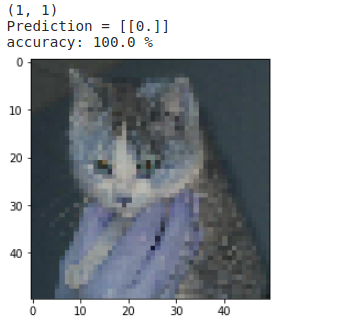